In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [10]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col]

In [11]:
##################################
##### Define hyperparameters #####
##################################

param_grid_xg = {
    'clf__n_estimators': [100, 150],
    'clf__max_depth': [3, 5, 10],
    'clf__learning_rate': [0.1, 0.01],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

In [13]:
###########################
##### Train the model #####
###########################
fbeta = make_scorer(fbeta_score, beta=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(random_state=42))
])

kF = KFold(n_splits=5, shuffle=True, random_state=42)

xgboost_grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid_xg,
    scoring=fbeta,
    cv=kF,
    n_jobs=-1,
    verbose=1
)

xgboost_grid.fit(X_train, y_train)
best_xgboost_model = xgboost_grid.best_estimator_
# Make predictions and print classification report
y_pred = best_xgboost_model.predict(X_test)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 150, 'clf__subsample': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3361
           1       0.98      0.82      0.89       246

    accuracy                           0.99      3607
   macro avg       0.98      0.91      0.94      3607
weighted avg       0.99      0.99      0.99      3607

F2 Score: 0.8445378151260504


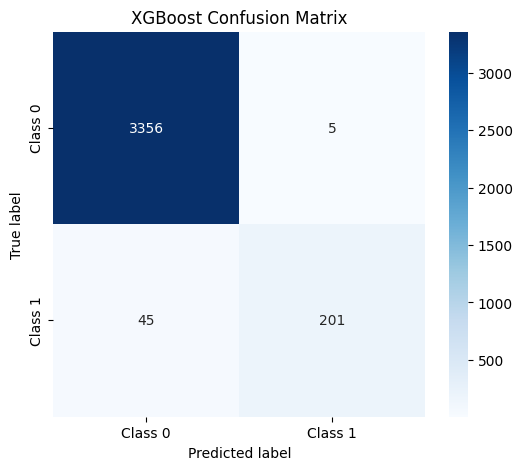

In [14]:
###########################
##### Display results #####
###########################

print("Best parameters:", xgboost_grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"XGBoost Confusion Matrix")

In [15]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = 'models/xgboost_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_xgboost_model, file)